# Lecture 3: Basic Models in TensorFlow
## 1. Overview
1. Review
1. Linear regression in TensorFlow
1. Optimizers
1. Logistic regression on MNIST
1. Loss functions


[github](https://github.com/chiphuyen/tf-stanford-tutorials)
- examples: 
    - 03_linear_regression_starter.py
    - 03_logistic_regression_mnist_starter.py
- data: fire_theft.xls

## 2. Linear regression
### example: Chicago fire theft
- X: number of incidents of fire
- Y: number of incidents of theft
- goal: Predict Y from X
- model: $Y_{predicted} = w * X + b$  
$(Y - Y_{predicted})^2$

### Phase 1: Assemble graph
- Step 1: Read in data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

/Users/yvonne/Documents/postCampus/MOOC/2017_Stanford_Tensorflow/project/venv/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


FileNotFoundError: [Errno 2] No such file or directory: 'data/fire_theft.xls'

In [6]:
DATA_FILE = 'data/fire_theft.xls'

book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

- Step 2: Create placeholders for inputs and labels

In [8]:
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

- Step 3: Create weight and bias  
`tf.Variable(initial_value=None, trainable=True, collections=None, name=None, dtype=None, ...)`

In [9]:
w = tf.Variable(0.0, name='weights')
b = tf.Variable(0.0, name='bias')

- Step 4: Build model to predict Y

In [10]:
Y_predicted = X * w + b 

- Step 5: Specify loss function

In [11]:
loss = tf.square(Y - Y_predicted, name='loss')

- Step 6: Create optimizer

In [12]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

### Phase 2: Train the model
- Initialize variables
- Run optimizer op
（with data fed into placeholders for inputs and labels）  

### See model in TensorBoard
- Step 1: `writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)`
- Step 2: `$ tensorboard --logdir='./my_graph'`

In [14]:
with tf.Session() as sess:
	# Step 7: initialize the necessary variables, in this case, w and b
	sess.run(tf.global_variables_initializer()) 
	
	writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)
	
	# Step 8: train the model
	for i in range(100): # train the model 100 times
		total_loss = 0
		for x, y in data:
			# Session runs train_op and fetch values of loss
			_, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y}) 
			total_loss += l
		print('Epoch {0}: {1}'.format(i, total_loss/n_samples))

	# close the writer when you're done using it
	writer.close() 
	
	# Step 9: output the values of w and b
	w_value, b_value = sess.run([w, b]) 

Epoch 0: 2069.6319333978354
Epoch 1: 2117.0123581953535
Epoch 2: 2092.302723001866
Epoch 3: 2068.5080461938464
Epoch 4: 2045.591184088162
Epoch 5: 2023.5146448101316
Epoch 6: 2002.2447619835536
Epoch 7: 1981.748338803649
Epoch 8: 1961.9944411260742
Epoch 9: 1942.9520116143283
Epoch 10: 1924.5930823644712
Epoch 11: 1906.8898800636332
Epoch 12: 1889.8164505837929
Epoch 13: 1873.347133841543
Epoch 14: 1857.4588400604468
Epoch 15: 1842.1278742424079
Epoch 16: 1827.332495119955
Epoch 17: 1813.0520579712022
Epoch 18: 1799.2660847636982
Epoch 19: 1785.9562132299961
Epoch 20: 1773.1024853109072
Epoch 21: 1760.689129482884
Epoch 22: 1748.6984157081515
Epoch 23: 1737.1138680398553
Epoch 24: 1725.920873066732
Epoch 25: 1715.1046249579008
Epoch 26: 1704.6500954309377
Epoch 27: 1694.5447134910141
Epoch 28: 1684.7746311347667
Epoch 29: 1675.328450968245
Epoch 30: 1666.1935385839038
Epoch 31: 1657.3584002084322
Epoch 32: 1648.8122658529207
Epoch 33: 1640.5440742547091
Epoch 34: 1632.5446836102221
Epo

### Plot the results with matplotlib


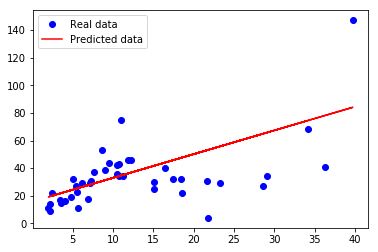

In [15]:
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w_value + b_value, 'r', label='Predicted data')
plt.legend()
plt.show()

## 3. Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    _, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
Session looks at all **trainable** variables that loss depends on and update them
### list of optimizers in TF
- tf.train.GradientDescentOptimizer
- tf.train.AdagradOptimizer
- tf.train.MomentumOptimizer
- tf.train.AdamOptimizer
- tf.train.ProximalGradientDescentOptimizer
- tf.train.ProximalAdagradOptimizer
- tf.train.RMSPropOptimizer  
And more  
### improve model: Huber loss
- Robust to outliers
- Intuition:  
    - if the difference between the predicted value and the real value is small, square it  
    - If it’s large, take its absolute value
- Implementation: can't write $if\ Y - Y_{predicted} < delta$

In [ ]:
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * tf.square(residual)
    large_res = delta * residual - 0.5 * tf.square(delta)
    return tf.select(condition, small_res, large_res)


## 4. Logistic Regression
### MNIST Database
![MNIST](figures/03_01.png)  

- Each image is a 28x28 array, flattened out to be a 1-d tensor of size 784
- X: image of a handwritten digit
- Y: the digit value
- goal: Recognize the digit in the image
- model: 
    - logits = X * w + b
    - Y_predicted = softmax(logits)
    - loss = cross_entropy(Y, Y_predicted)
    
### Batch ‘em up  
    X = tf.placeholder(tf.float32, [batch_size, 784], name="image")
    Y = tf.placeholder(tf.float32, [batch_size, 10], name="label")
### Process data
    from tensorflow.examples.tutorials.mnist import input_data
    
    # using TF Learn's built in function to load MNIST data to the folder data/mnist
    MNIST = input_data.read_data_sets("/data/mnist", one_hot=True)
    
    # MNIST.train: 55,000 examples
    # MNIST.validation: 5,000 examples
    # MNIST.test: 10,000 examples
    
### Phase 1: Assemble our graph
- Step 2: Create placeholders for inputs and labels
        X = tf.placeholder(tf.float32, [batch_size, 784], name="image")
        Y = tf.placeholder(tf.float32, [batch_size, 10], name="label")
- Step 3: Create weight and bias
        w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name='weights')
        b = tf.Variable(tf.zeros([1, 10]), name="bias")
- Step 4: Build model to predict Y  
        # the model that returns the logits.
            # this logits will be later passed through softmax layer
        logits = tf.matmul(X, w) + b 
- Step 5: Specify loss function 
        # use cross entropy of softmax of logits as the loss function
        entropy = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='loss')
        loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch
- Step 6: Create optimizer
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        
    - add new operations to the computation graph: ones to compute gradients, compute parameter update steps, and apply update steps to the parameters
    - when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running optimizer



### Phase 2: Train our model

(https://www.tensorflow.org/get_started/mnist/pros)  

        with tf.Session() as sess:
            # to visualize using TensorBoard
            writer = tf.summary.FileWriter('./my_graph/03/logistic_reg', sess.graph)

            start_time = time.time()
            sess.run(tf.global_variables_initializer())	
            n_batches = int(mnist.train.num_examples/batch_size)
            for i in range(n_epochs): # train the model n_epochs times
                total_loss = 0

                for _ in range(n_batches):
                    X_batch, Y_batch = mnist.train.next_batch(batch_size)
                    _, loss_batch = sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch}) 
                    total_loss += loss_batch
                print 'Average loss epoch {0}: {1}'.format(i, total_loss/n_batches)

            print 'Total time: {0} seconds'.format(time.time() - start_time)

            print('Optimization Finished!') # should be around 0.35 after 25 epochs

            # test the model
            n_batches = int(mnist.test.num_examples/batch_size)
            total_correct_preds = 0
            for i in range(n_batches):
                X_batch, Y_batch = mnist.test.next_batch(batch_size)
                _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict={X: X_batch, Y:Y_batch}) 
                preds = tf.nn.softmax(logits_batch)
                correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
                accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32)) # need numpy.count_nonzero(boolarr) :(
                total_correct_preds += sess.run(accuracy)	

            print 'Accuracy {0}'.format(total_correct_preds/mnist.test.num_examples)

            writer.close()